In [4]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import shapely
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon, shape
from shapely.affinity import scale
#import geoplot

# Asthma Disease Indicator Analysis

The purpose of this notebook is to explore two different datasets for their usability as the Asthma Indicator for CO

#### Dataset Info

The current dataset being used is Asthma-related hospital discharge among adults (18+) per census tract. The alternative is the modeled prevalence of asthma in a census tract.

Modeled Prevalence of Asthma: https://data-cdphe.opendata.arcgis.com/datasets/99d966b6ab75450c93569a3f112f3002_1

Asthma hospitalization: https://data-cdphe.opendata.arcgis.com/datasets/asthma-hospitalization-rate-census-tracts

#### CES methodology

CalEnviroScreen currently using the number of emergency department visits and lists it as "the best available way of describing differences in asthma across the state at the census tract scale".  It is especially important that we focus on picking an indicator that helps us describe the difference in asthma across states.

### Surface-Level Pros and Cons

###### Modeled Prevalence

Pros
- We have decided to use modeled prevalence for the heart disease indicator so for consistency sake this makes sense
- modeled prevalence helps capture those that have asthma but have not been hospitalized for it


Cons
- The data is based off modeling and not direct survey estimates
- The modeling uses the relationship between age, race, gender, poverty, education, location and health conditions or risk behavior indicators which means that any bias present in any of these indicators leaks into the modeling estimates



###### Hospital Discharges

Pros
- A bit more empirical than modeled prevalence
- Hospitalization helps track the more serious cases of asthma, supposedly tying into the worsening of asthma from air pollution


Cons
- We fail to capture those with asthma who do not go to the hospital

## Data Analysis

In [5]:
modeled = pd.read_csv("data/Asthma_Prevalence_in_Adults_-_CDPHE_Community_Level_Estimates__Census_Tracts_.csv")
hospital = pd.read_csv("data/Asthma_Hospitalization_Rate_Census_Tracts.csv")

In [6]:
modeled.head()

,OBJECTID,Census_Tract_FIPS,Census_Tract_Name,County_Name,Adult_Population_Age18_and_over,Health_Statistics_Region,Asthma_Census_Tract_Estimate,Asthma_Estimate_Confidence_Interval,Asthma_Map_Symbol_withinHSR,Asthma_County_Regional_Estimate,Asthma_Map_Symbol_State,Asthma_State_Estimate
0,1,8043979000,"Census Tract 9790, Fremont County, Colorado",Fremont,2994,13,9.1,95% C.I.: 7.9 - 10.5,Fourth Quintile,County/Regional Estimate 9.9% (95% C.I.: 7.1 -...,Fourth Quintile,State Estimate 8.9% (95% C.I.: 8.5 - 9.2)
1,2,8045951600,"Census Tract 9516, Garfield County, Colorado",Garfield,2800,12,7.9,95% C.I.: 6.8 - 9.2,Middle Quintile,County/Regional Estimate 5.1% (95% C.I.: 3.1 -...,Lowest Quintile,State Estimate 8.9% (95% C.I.: 8.5 - 9.2)
2,3,8069002803,"Census Tract 28.03, Larimer County, Colorado",Larimer,97,2,9.8,95% C.I.: 8.8 - 10.8,Highest Quintile,County/Regional Estimate 8.4% (95% C.I.: 7 - 9.7),Highest Quintile,State Estimate 8.9% (95% C.I.: 8.5 - 9.2)
3,4,8125963200,"Census Tract 9632, Yuma County, Colorado",Yuma,4381,1,8.1,95% C.I.: 6.8 - 9.7,Lowest Quintile,County/Regional Estimate 4% (95% C.I.: 1.7 - 6.4),Lowest Quintile,State Estimate 8.9% (95% C.I.: 8.5 - 9.2)
4,5,8069002401,"Census Tract 24.01, Larimer County, Colorado",Larimer,1190,2,8.2,95% C.I.: 7.4 - 9.1,Lowest Quintile,County/Regional Estimate 8.4% (95% C.I.: 7 - 9.7),Lowest Quintile,State Estimate 8.9% (95% C.I.: 8.5 - 9.2)


In [7]:
hospital.head()

,OBJECTID,TRACT_FIPS,ASTHMA_ADJRATE,ASTHMA_L95CI,ASTHMA_U95CI,ASTHMA_STATEADJRATE,ASTHMA_SL95CI,ASTHMA_SU95CI,TRACT_NAME,COUNTY_NAME,ASTHMA_DISPLAY
0,1,8043979000,527.94,356.66,699.23,637.8,634.79,640.81,"Census Tract 9790, Fremont County, Colorado",FREMONT,Not Different Than State Average
1,2,8045951600,266.94,189.53,344.35,637.8,634.79,640.81,"Census Tract 9516, Garfield County, Colorado",GARFIELD,Lower Than State Average
2,3,8069002803,0.00,0.00,0.00,637.8,634.79,640.81,"Census Tract 28.03, Larimer County, Colorado",LARIMER,No Events or Data Suppressed
3,4,8125963200,350.95,281.08,420.83,637.8,634.79,640.81,"Census Tract 9632, Yuma County, Colorado",YUMA,Lower Than State Average
4,5,8069002401,1002.35,285.47,1719.23,637.8,634.79,640.81,"Census Tract 24.01, Larimer County, Colorado",LARIMER,Not Different Than State Average


In [10]:
hospital = hospital[["TRACT_FIPS", "ASTHMA_ADJRATE", "TRACT_NAME", "COUNTY_NAME", "ASTHMA_DISPLAY"]]
modeled = modeled[["Census_Tract_FIPS", "Asthma_Census_Tract_Estimate","Census_Tract_Name", "County_Name"]]

In [15]:
hospital["rank"] = hospital["ASTHMA_ADJRATE"].rank(pct = True, na_option = 'keep')*100
modeled["rank"] = modeled["Asthma_Census_Tract_Estimate"].rank(pct = True, na_option = 'keep')*100

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
hospital.head()

,TRACT_FIPS,ASTHMA_ADJRATE,TRACT_NAME,COUNTY_NAME,ASTHMA_DISPLAY,rank
0,8043979000,527.94,"Census Tract 9790, Fremont County, Colorado",FREMONT,Not Different Than State Average,35.024155
1,8045951600,266.94,"Census Tract 9516, Garfield County, Colorado",GARFIELD,Lower Than State Average,8.132045
2,8069002803,0.00,"Census Tract 28.03, Larimer County, Colorado",LARIMER,No Events or Data Suppressed,0.483092
3,8125963200,350.95,"Census Tract 9632, Yuma County, Colorado",YUMA,Lower Than State Average,14.734300
4,8069002401,1002.35,"Census Tract 24.01, Larimer County, Colorado",LARIMER,Not Different Than State Average,85.426731


In [17]:
modeled.head()

,Census_Tract_FIPS,Asthma_Census_Tract_Estimate,Census_Tract_Name,County_Name,rank
0,8043979000,9.1,"Census Tract 9790, Fremont County, Colorado",Fremont,68.266129
1,8045951600,7.9,"Census Tract 9516, Garfield County, Colorado",Garfield,6.653226
2,8069002803,9.8,"Census Tract 28.03, Larimer County, Colorado",Larimer,89.193548
3,8125963200,8.1,"Census Tract 9632, Yuma County, Colorado",Yuma,13.951613
4,8069002401,8.2,"Census Tract 24.01, Larimer County, Colorado",Larimer,18.225806


One idea is that data with more of a distribution spread could be better for indicator use as it may help to show more of the difference in Asthma across states

Text(0.5,0,'Modeled Asthma Rate')

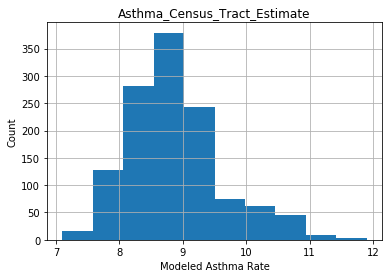

In [21]:
modeled.hist("Asthma_Census_Tract_Estimate")
plt.ylabel("Count")
plt.xlabel("Modeled Asthma Rate")

Text(0.5,0,'Number of Asthma Hospital Discharges')

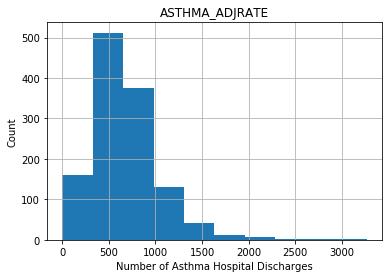

In [22]:
hospital.hist("ASTHMA_ADJRATE")
plt.ylabel("Count")
plt.xlabel("Number of Asthma Hospital Discharges")

Interesting to note that the modeled data has no zero data and a bit more of spread around the tail whereas the hospital discharges are centered around the lower bins

In [23]:
hospital["ASTHMA_ADJRATE"].isna().sum()

7

In [24]:
modeled["Asthma_Census_Tract_Estimate"].isna().sum()

9

The hospital data has 2 fewer na values not a huge difference

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa16ce45b70>]],
      dtype=object)

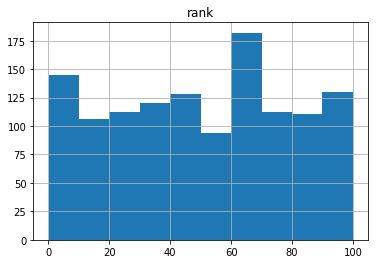

In [25]:
modeled.hist("rank")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa16d222550>]],
      dtype=object)

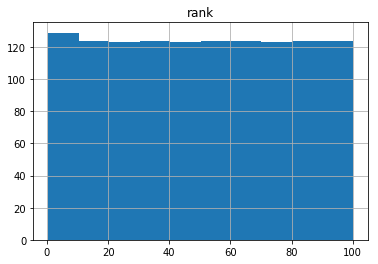

In [26]:
hospital.hist("rank")

The hospital data is almost perfectly even in its spread of percentile ranks whereas there is a lot more variation in the modeled data.

In [27]:
modeled[modeled["Asthma_Census_Tract_Estimate"] == min(modeled["Asthma_Census_Tract_Estimate"])]

,Census_Tract_FIPS,Asthma_Census_Tract_Estimate,Census_Tract_Name,County_Name,rank
601,8073961700,7.1,"Census Tract 9617, Lincoln County, Colorado",Lincoln,0.080645


In [28]:
hospital[hospital["ASTHMA_ADJRATE"] == min(hospital["ASTHMA_ADJRATE"])]

,TRACT_FIPS,ASTHMA_ADJRATE,TRACT_NAME,COUNTY_NAME,ASTHMA_DISPLAY,rank
2,8069002803,0.0,"Census Tract 28.03, Larimer County, Colorado",LARIMER,No Events or Data Suppressed,0.483092
35,8037000501,0.0,"Census Tract 5.01, Eagle County, Colorado",EAGLE,No Events or Data Suppressed,0.483092
462,8123000300,0.0,"Census Tract 3, Weld County, Colorado",WELD,No Events or Data Suppressed,0.483092
485,8014980100,0.0,"Census Tract 9801, Broomfield County, Colorado",BROOMFIELD,No Events or Data Suppressed,0.483092
494,8014980300,0.0,"Census Tract 9803, Broomfield County, Colorado",BROOMFIELD,No Events or Data Suppressed,0.483092
513,8014980200,0.0,"Census Tract 9802, Broomfield County, Colorado",BROOMFIELD,No Events or Data Suppressed,0.483092
544,8043980200,0.0,"Census Tract 9802, Fremont County, Colorado",FREMONT,No Events or Data Suppressed,0.483092
548,8043980300,0.0,"Census Tract 9803, Fremont County, Colorado",FREMONT,No Events or Data Suppressed,0.483092
551,8043980100,0.0,"Census Tract 9801, Fremont County, Colorado",FREMONT,No Events or Data Suppressed,0.483092
670,8059980000,0.0,"Census Tract 9800, Jefferson County, Colorado",JEFFERSON,No Events or Data Suppressed,0.483092


In [29]:
modeled[modeled["Asthma_Census_Tract_Estimate"] == max(modeled["Asthma_Census_Tract_Estimate"])]

,Census_Tract_FIPS,Asthma_Census_Tract_Estimate,Census_Tract_Name,County_Name,rank
90,8083941100,11.9,"Census Tract 9411, Montezuma County, Colorado",Montezuma,99.959677
726,8101000903,11.9,"Census Tract 9.03, Pueblo County, Colorado",Pueblo,99.959677


In [30]:
hospital[hospital["ASTHMA_ADJRATE"] == max(hospital["ASTHMA_ADJRATE"])]

,TRACT_FIPS,ASTHMA_ADJRATE,TRACT_NAME,COUNTY_NAME,ASTHMA_DISPLAY,rank
1187,8041002300,3267.16,"Census Tract 23, El Paso County, Colorado",EL PASO,Higher Than State Average,100.0
